# Procedure (*** means demonstrated)
1. Data exploration & visualization ***
2. Holdout (splitting data) ***
3. SelectKbest ***
     - gridsearchCV ***
     - Decision tree model
         + Cross validation
         + Confusion matrix
         + Classification_report
     - Random forest model ***
         + Cross validation (not sure)
         + Confusion matrix ***
         + Classification_report ***
4. PCA
     - gridsearchCV
     - Decision tree model
         + Cross validation
         + Confusion matrix
         + Classification_report
     - Random forest model
         + Cross validation
         + Confusion matrix
         + Classification_report
5. Do the write-up analysis and conclusions, make sure that you include time execution for the models.)

ref:
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

### 0. Load data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [11]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
#     'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    './LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

C:\Users\kefei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


### 1. EDA
##### data cleaning
- This dataset has 100+ non-null columns, 400,000+ non-null records. 
- For the first atempt, we can just drop all the columns with null values, instead of imputation.
- Note that, the afformentioned strategy is for numerical features; for categorical features, the null values can be handeled by using one-hot-encoding.
- Also note that, in order to make the training set and test set have same features, we will first split the data into training set and test set, then perform one-hot-encoding and dropna.
#### data exploration
- The target is categorical, we are working on classification problem. So, we use bar plot to show the number of each categories. (It might raise some concern if the number of each categories are too unbalanced)
- For each feature, since there are too many, it is very hard to plot them all or analyze individual feature. Later on we will use SelectKbest method for feature engineering.

In [13]:
# 'object' type data info
df_object = y2015.select_dtypes(include=['object'])
print(df_object.info())

# 'float' type data info
df_float = y2015.select_dtypes(include=['float'])
print(df_float.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   id                         421097 non-null  object
 1   term                       421095 non-null  object
 2   int_rate                   421095 non-null  object
 3   grade                      421095 non-null  object
 4   sub_grade                  421095 non-null  object
 5   emp_title                  397221 non-null  object
 6   emp_length                 397278 non-null  object
 7   home_ownership             421095 non-null  object
 8   verification_status        421095 non-null  object
 9   issue_d                    421095 non-null  object
 10  loan_status                421095 non-null  object
 11  pymnt_plan                 421095 non-null  object
 12  url                        421095 non-null  object
 13  desc                       45 non-null      

In [14]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')


# explore columns with nan falues
null_col_list = []
for col in y2015.columns:
    if y2015[col].isna().any():
        null_col_list.append(col)
        
null_col_list
# len(null_col_list)
y2015[null_col_list].info()

# in this dataset, since we already have a lot of columns, we can drop all the columns with nan instead of imputation.
# df = y2015.drop(null_col_list, axis = 1)
df= y2015.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   emp_title                       397221 non-null  object 
 1   emp_length                      397278 non-null  object 
 2   desc                            45 non-null      object 
 3   title                           420963 non-null  object 
 4   mths_since_last_delinq          217133 non-null  float64
 5   mths_since_last_record          74415 non-null   float64
 6   revol_util                      420933 non-null  object 
 7   last_pymnt_d                    420801 non-null  object 
 8   next_pymnt_d                    303928 non-null  object 
 9   last_credit_pull_d              421087 non-null  object 
 10  mths_since_last_major_derog     122729 non-null  float64
 11  annual_inc_joint                511 non-null     float64
 12  dti_joint       

In [15]:
# get dummy, but be careful not make too large a dummy dataset, drop those columns with too many categories (>80)
df_object = df.select_dtypes(include='object')
col_drop_list = []
for col in df_object.columns:
#     column = df_object[i]
    print(col)
    print(df_object[col].nunique())
    if df_object[col].nunique() > 80:
        col_drop_list.append(col)
        
# col_drop_list
# type(df_object[i])

df = df.drop(col_drop_list, axis = 1)
df.info()

# # make dummy
# df_dummy = pd.get_dummies(df)
# df_dummy.info()

term
2
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 106 entries, id to total_il_high_credit_limit
dtypes: float64(86), int64(1), object(19)
memory usage: 340.5+ MB


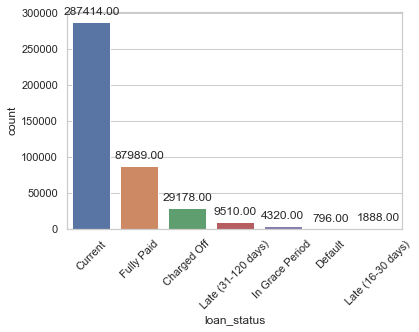

In [30]:
df['loan_status'].value_counts()

import seaborn as sns

sns.set(style="whitegrid")
splot = sns.countplot(x="loan_status",data=df[['loan_status']])
plt.xticks(rotation = 45)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### 2. Split

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop('loan_status', axis=1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)



### 3. select K best, gridSearch 

In [18]:
# using chi-squre to select the top 200 features.
from sklearn.feature_selection import SelectKBest, chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
dftypes = pd.DataFrame(X_train.dtypes.values)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores, dftypes],axis=1)
# featureScores['dftypes'] = dftypes
featureScores.columns = ['Specs','Score','dftypes']  #naming the dataframe columns


print(featureScores.nlargest(200,'Score'))


                 Specs         Score  dftypes
1            member_id  1.486545e+10  float64
0                   id  1.393830e+10    int64
24     last_pymnt_amnt  2.311335e+09  float64
15           out_prncp  9.402891e+08  float64
16       out_prncp_inv  9.398738e+08  float64
..                 ...           ...      ...
227      addr_state_ME  3.476033e+01    uint8
236      addr_state_NH  3.469943e+01    uint8
102  emp_length_1 year  2.975465e+01    uint8
237      addr_state_NJ  2.900023e+01    uint8
222      addr_state_KS  2.864860e+01    uint8

[200 rows x 3 columns]


In [19]:
# take the K best score (k = 10, 50 or 100)
take_k = 10
X_train_KBest = X_train[featureScores.nlargest(take_k,'Score')['Specs'].values].copy()
# X_train_KBest

X_test_KBest = X_test[X_train_KBest.columns].copy()
# X_test_KBest


In [20]:
# fast check if taking k feature is sactifactory using default hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(verbose=1, n_estimators=10, n_jobs=-1)

cross_val_score(rfc, X_train_KBest, y_train, cv=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Paral

array([0.97346236, 0.97393731, 0.97408573, 0.97408573, 0.97390762,
       0.97467941, 0.97405527, 0.97402559, 0.97358031, 0.97402559])

#### 3.2 random forest

#### Random Search with Cross Validation
first use random search to narrow down the parameter settings, then use gridsearch to get more combinations

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 36, 63, 90, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(random_state=42, verbose=3)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid,
                              n_iter = 20, scoring='accuracy', 
                              cv = 5, verbose=3, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rfc_random.fit(X_train_KBest, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   32.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [23]:
rfc_random.best_params_

{'n_estimators': 20,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

### Evaluation Function

In [24]:
print(rfc_random.best_score_)
print(rfc_random.best_estimator_)


0.9755102777468145
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=3,
                       warm_start=False)


In [25]:
rfc_random.cv_results_

{'mean_fit_time': array([ 11.54547133,  82.51191082,  37.17609277, 115.68711743,
         56.56869822,  59.10422873, 100.21434879,  20.7027216 ,
         34.74934549,  24.42631512, 102.54819198,  66.88266912,
         58.99249215,  20.93249526,  58.90289202,  30.9867322 ,
         79.56012611,  61.02799463,  51.66127605,  29.70564895]),
 'std_fit_time': array([0.10486135, 0.76247796, 0.24667303, 1.97837429, 0.43571269,
        0.67860399, 1.05937627, 0.62902787, 0.17267813, 0.82944516,
        1.23445306, 0.70256441, 1.00621401, 0.35838639, 0.84480015,
        0.39362212, 0.24313919, 0.36043251, 7.11264492, 0.13300518]),
 'mean_score_time': array([0.30318933, 0.90218854, 0.63533344, 1.1916141 , 0.87665639,
        0.80564575, 1.46988988, 0.42806525, 0.63371053, 0.51562138,
        1.42590947, 0.70632877, 0.68149409, 0.44441137, 0.70982213,
        0.48501225, 1.12981167, 0.93581777, 0.69634461, 0.43865213]),
 'std_score_time': array([0.01532007, 0.0210587 , 0.01740092, 0.02228665, 0.04

### Grid Search with Cross Validation


In [26]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3],
    'n_estimators': [10, 20, 30]
}
# Create a based model
rfc = RandomForestClassifier(random_state=42, verbose=3)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 3)


# Fit the random search model
grid_search.fit(X_train_KBest, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 19.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   46.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [27]:
print(grid_search.best_params_)
print('-------------------------------------')
print(grid_search.best_score_)
print('-------------------------------------')
print(grid_search.best_estimator_)
print('-------------------------------------')
print(grid_search.cv_results_)

{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 30}
-------------------------------------
0.9755369940640491
-------------------------------------
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=3,
                       warm_start=False)
-------------------------------------
{'mean_fit_time': array([12.07410393, 23.23862658, 34.8152432 , 12.22914562, 23.52341785,
       34.93392749, 12.34598937, 23.84449668, 35.52536697, 12.36051502,
       24.31339192, 35.552089

### Evaluation on the test data

In [28]:
#Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create the final RF classifier

parameter = {'n_estimators': 40, 
             'min_samples_split': 2,
             'min_samples_leaf': 1,
             'max_features': 'sqrt',
             'max_depth': 36, 
             'bootstrap': False}
# Create a based model
rfc = RandomForestClassifier(**parameter, random_state=42, verbose=3, n_jobs=-1)
rfc.fit(X_train_KBest, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40

building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.9s



building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:   11.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   13.2s finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=36, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=3,
                       warm_start=False)

In [29]:
y_pred=rfc.predict(X_test_KBest)

print(confusion_matrix(y_test,y_pred))
print('----------------------------')
print(classification_report(y_test,y_pred))
print('----------------------------')
print(accuracy_score(y_test, y_pred))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  31 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  40 out of  40 | elapsed:    0.1s finished


[[ 5822     0     0    41     0     0     0]
 [    0 57254     8     5    93    26    82]
 [    0     0    19     0     0     0   149]
 [   24     0     0 17602     0     0     0]
 [    0   831     0     0    21     5    19]
 [    0   306     0     0    16     8    37]
 [    0   390    18     0    13    19  1411]]
----------------------------
                    precision    recall  f1-score   support

       Charged Off       1.00      0.99      0.99      5863
           Current       0.97      1.00      0.99     57468
           Default       0.42      0.11      0.18       168
        Fully Paid       1.00      1.00      1.00     17626
   In Grace Period       0.15      0.02      0.04       876
 Late (16-30 days)       0.14      0.02      0.04       367
Late (31-120 days)       0.83      0.76      0.80      1851

          accuracy                           0.98     84219
         macro avg       0.64      0.56      0.58     84219
      weighted avg       0.96      0.98      0.97    